# Phase 6: Advanced ML Modeling & Final Comparison

**Goal:** Train a Random Forest on 10 years of engineered features, simulate remaining games with `predict_proba`, and compare against the Elo baseline.

| Step | Cell | Description |
|------|------|-------------|
| Setup | Cell 1 | Load engineered data + Elo baseline |
| Training | Cell 2 | Random Forest with temporal validation |
| Importance | Cell 3 | Feature importance chart (Professor's proof) |
| Simulation | Cell 4 | Monte Carlo with `predict_proba` |
| Comparison | Cell 5 | ML vs Elo: final showdown |
| Report | Cell 6 | Save all outputs + comparison viz |

### Key Difference from Phase 4
| | Phase 4 (Elo Baseline) | Phase 6 (ML Model) |
|---|---|---|
| **Probabilities** | Elo formula + league constants | Random Forest `predict_proba` |
| **Features** | Only Elo ratings | Elo + Form + xG + Finishing + Rest |
| **Per-matchup** | Same formula for all | Custom prediction per matchup |

In [1]:
# =============================================================================
# Cell 1: Setup & Load Data
# =============================================================================

import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')
np.random.seed(42)

PROCESSED_DIR = os.path.join('data', 'processed')
RESULTS_DIR = os.path.join('data', 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

N_SIMULATIONS = 10_000

# --- Load engineered data ---
print('Loading engineered data...')
training = pd.read_csv(os.path.join(PROCESSED_DIR, 'model_training_engineered.csv'), low_memory=False)
banked = pd.read_csv(os.path.join(PROCESSED_DIR, 'current_banked_engineered.csv'), low_memory=False)
future = pd.read_csv(os.path.join(PROCESSED_DIR, 'future_predict_engineered.csv'), low_memory=False)
elo_baseline = pd.read_csv(os.path.join(RESULTS_DIR, 'Baseline_Elo_Projection.csv'))

print(f'  Training:     {len(training):>7,} rows')
print(f'  Banked:       {len(banked):>7,} rows')
print(f'  Future:       {len(future):>7,} rows')
print(f'  Elo Baseline: {len(elo_baseline):>7,} rows')

# --- Define feature set ---
FEATURES = [
    'elo_diff',
    'home_form_l5',
    'away_form_l5',
    'form_diff_l5',
    'home_finishing_efficiency_l5',
    'away_finishing_efficiency_l5',
    'home_attacking_xg_l5',
    'away_attacking_xg_l5',
    'home_defensive_xg_l5',
    'away_defensive_xg_l5',
    'home_rest_days',
    'away_rest_days',
]

# Pretty names for display
FEATURE_LABELS = [
    'Elo Difference',
    'Home Form (L5)',
    'Away Form (L5)',
    'Form Difference (L5)',
    'Home Finishing Efficiency (L5)',
    'Away Finishing Efficiency (L5)',
    'Home Attacking xG (L5)',
    'Away Attacking xG (L5)',
    'Home Defensive xG (L5)',
    'Away Defensive xG (L5)',
    'Home Rest Days',
    'Away Rest Days',
]

TARGET = 'FTR'

# Encode target: H=2, D=1, A=0
TARGET_MAP = {'A': 0, 'D': 1, 'H': 2}
TARGET_NAMES = ['Away Win', 'Draw', 'Home Win']

print(f'\nFeatures: {len(FEATURES)}')
for f in FEATURES:
    print(f'  - {f}')
print(f'Target: {TARGET} -> {TARGET_MAP}')

Loading engineered data...
  Training:      19,837 rows
  Banked:         1,104 rows
  Future:           648 rows
  Elo Baseline:      96 rows

Features: 12
  - elo_diff
  - home_form_l5
  - away_form_l5
  - form_diff_l5
  - home_finishing_efficiency_l5
  - away_finishing_efficiency_l5
  - home_attacking_xg_l5
  - away_attacking_xg_l5
  - home_defensive_xg_l5
  - away_defensive_xg_l5
  - home_rest_days
  - away_rest_days
Target: FTR -> {'A': 0, 'D': 1, 'H': 2}


In [2]:
# =============================================================================
# Cell 2: Random Forest Training with Temporal Validation
# =============================================================================
# We use temporal split: train on older seasons, test on most recent.
# This prevents data leakage from the future.

print('Training Random Forest Classifier...')
print('=' * 65)

# --- Prepare data ---
model_data = training.dropna(subset=[TARGET]).copy()
model_data['y'] = model_data[TARGET].map(TARGET_MAP)

# Drop rows where features are NaN (first few matches per team)
model_data = model_data.dropna(subset=FEATURES + ['y'])
print(f'Usable training rows (after NaN drop): {len(model_data):,}')

# --- Temporal split ---
# Train: all seasons except the last (2425)
# Test: last season (2425) -- simulates predicting unseen future
last_season = model_data['season'].max()
train_mask = model_data['season'] < last_season
test_mask  = model_data['season'] == last_season

X_train = model_data.loc[train_mask, FEATURES]
y_train = model_data.loc[train_mask, 'y']
X_test  = model_data.loc[test_mask, FEATURES]
y_test  = model_data.loc[test_mask, 'y']

print(f'\nTemporal split:')
print(f'  Train: {len(X_train):,} matches (seasons < {last_season})')
print(f'  Test:  {len(X_test):,} matches (season {last_season})')

# --- Impute any remaining NaN (edge cases) ---
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# --- Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train_imp, y_train)

# --- Evaluate ---
y_pred = rf.predict(X_test_imp)
accuracy = accuracy_score(y_test, y_pred)

print(f'\n{"=" * 65}')
print(f'MODEL PERFORMANCE (Test Set: Season {last_season})')
print(f'  Accuracy: {accuracy:.1%} (Random baseline: 33.3%)')
print(f'  Improvement over random: {(accuracy - 1/3) / (1/3):.0%}')
print(f'\n{classification_report(y_test, y_pred, target_names=TARGET_NAMES)}')

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(f'  {"":12s} Pred Away  Pred Draw  Pred Home')
for i, name in enumerate(TARGET_NAMES):
    print(f'  {name:12s} {cm[i,0]:>9d} {cm[i,1]:>10d} {cm[i,2]:>10d}')

# --- Retrain on ALL historical data for final predictions ---
print(f'\nRetraining on full dataset ({len(model_data):,} rows) for production predictions...')
X_all = model_data[FEATURES]
y_all = model_data['y']
X_all_imp = imputer.fit_transform(X_all)
rf.fit(X_all_imp, y_all)
print('Final model trained.')

Training Random Forest Classifier...
Usable training rows (after NaN drop): 19,358

Temporal split:
  Train: 17,645 matches (seasons < 2425)
  Test:  1,713 matches (season 2425)

MODEL PERFORMANCE (Test Set: Season 2425)
  Accuracy: 49.7% (Random baseline: 33.3%)
  Improvement over random: 49%

              precision    recall  f1-score   support

    Away Win       0.52      0.56      0.54       567
        Draw       0.27      0.23      0.25       431
    Home Win       0.59      0.61      0.60       715

    accuracy                           0.50      1713
   macro avg       0.46      0.47      0.46      1713
weighted avg       0.49      0.50      0.49      1713

Confusion Matrix:
               Pred Away  Pred Draw  Pred Home
  Away Win           315        128        124
  Draw               153         98        180
  Home Win           137        139        439

Retraining on full dataset (19,358 rows) for production predictions...
Final model trained.


Generating Feature Importance Chart...

  Feature                               Importance
  -------------------------------------------------
  Elo Difference                            0.2882
  Away Attacking xG (L5)                    0.0897
  Home Attacking xG (L5)                    0.0865
  Form Difference (L5)                      0.0791
  Home Defensive xG (L5)                    0.0750
  Away Defensive xG (L5)                    0.0703
  Away Finishing Efficiency (L5)            0.0645
  Home Finishing Efficiency (L5)            0.0632
  Home Form (L5)                            0.0583
  Away Form (L5)                            0.0526
  Away Rest Days                            0.0364
  Home Rest Days                            0.0360


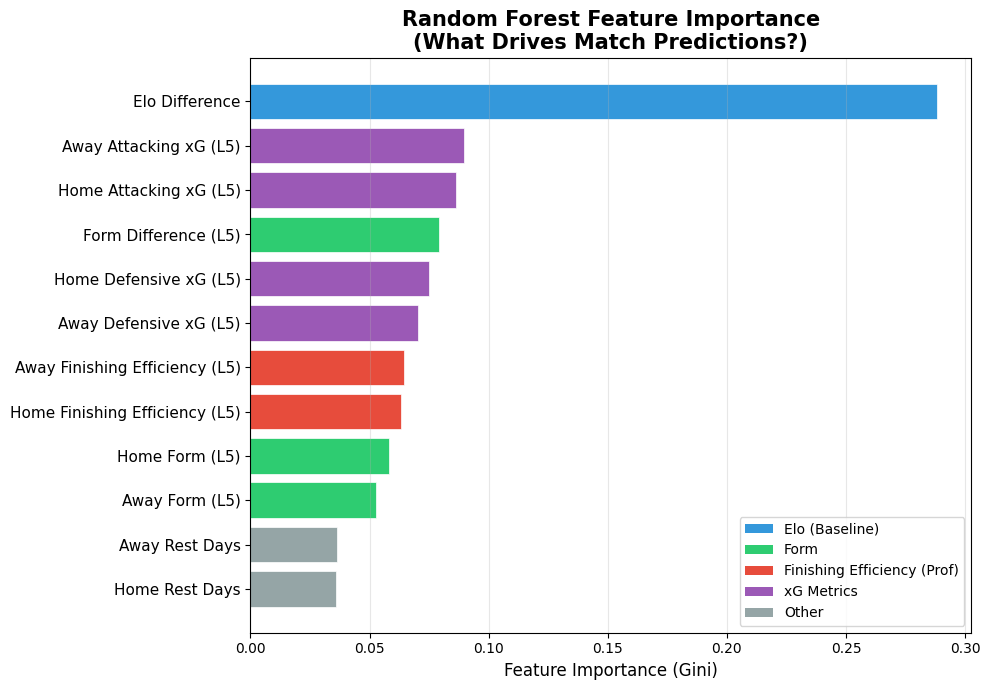


Saved: data\results\Feature_Importance.png


In [3]:
# =============================================================================
# Cell 3: Feature Importance (The Professor's Proof)
# =============================================================================

print('Generating Feature Importance Chart...')
print('=' * 65)

importances = rf.feature_importances_
indices = np.argsort(importances)

# Print table
print(f'\n  {"Feature":35s} {"Importance":>12s}')
print(f'  {"-"*49}')
for i in reversed(indices):
    print(f'  {FEATURE_LABELS[i]:35s} {importances[i]:12.4f}')

# --- Chart ---
fig, ax = plt.subplots(figsize=(10, 7))

colors = []
for i in indices:
    name = FEATURES[i]
    if 'finishing' in name:
        colors.append('#e74c3c')   # Red - Professor's feature
    elif 'elo' in name:
        colors.append('#3498db')   # Blue - Baseline
    elif 'form' in name:
        colors.append('#2ecc71')   # Green - Form
    elif 'xg' in name or 'attack' in name or 'defen' in name:
        colors.append('#9b59b6')   # Purple - xG
    else:
        colors.append('#95a5a6')   # Gray - Other

ax.barh(range(len(indices)), importances[indices], color=colors, edgecolor='white', linewidth=0.5)
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([FEATURE_LABELS[i] for i in indices], fontsize=11)
ax.set_xlabel('Feature Importance (Gini)', fontsize=12)
ax.set_title('Random Forest Feature Importance\n(What Drives Match Predictions?)',
             fontsize=15, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Elo (Baseline)'),
    Patch(facecolor='#2ecc71', label='Form'),
    Patch(facecolor='#e74c3c', label='Finishing Efficiency (Prof)'),
    Patch(facecolor='#9b59b6', label='xG Metrics'),
    Patch(facecolor='#95a5a6', label='Other'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()

importance_path = os.path.join(RESULTS_DIR, 'Feature_Importance.png')
plt.savefig(importance_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'\nSaved: {importance_path}')

In [4]:
# =============================================================================
# Cell 4: Monte Carlo Simulation with predict_proba
# =============================================================================
# Same engine as Phase 4, but probabilities come from the RF model.

print(f'Running {N_SIMULATIONS:,} Monte Carlo iterations (ML model)...')
print('=' * 65)

# --- Prepare future fixtures ---
X_future = future[FEATURES].copy()
X_future_imp = imputer.transform(X_future)

# --- Get ML probabilities: [P(Away), P(Draw), P(Home)] ---
ml_probs = rf.predict_proba(X_future_imp)  # shape: (n_fixtures, 3)

print(f'  Fixtures to simulate: {len(X_future)}')
print(f'  Probability shape: {ml_probs.shape}')
print(f'  Classes: {rf.classes_} -> {TARGET_NAMES}')
print(f'  P(Home) range: {ml_probs[:, 2].min():.3f} - {ml_probs[:, 2].max():.3f}')
print(f'  P(Draw) range: {ml_probs[:, 1].min():.3f} - {ml_probs[:, 1].max():.3f}')
print(f'  P(Away) range: {ml_probs[:, 0].min():.3f} - {ml_probs[:, 0].max():.3f}')

# --- Build team index ---
n_fixtures = len(future)
team_leagues = {}
for _, row in future.iterrows():
    team_leagues[row['home_team']] = row['league']
    team_leagues[row['away_team']] = row['league']

all_teams = sorted(team_leagues.keys())
team_idx = {t: i for i, t in enumerate(all_teams)}
n_teams = len(all_teams)

home_indices = np.array([team_idx[t] for t in future['home_team']])
away_indices = np.array([team_idx[t] for t in future['away_team']])

# --- Simulate ---
points_matrix = np.zeros((N_SIMULATIONS, n_teams), dtype=np.int32)

# Probabilities: col 0=Away, col 1=Draw, col 2=Home
for sim in range(N_SIMULATIONS):
    rands = np.random.random(n_fixtures)
    
    # Outcome: Away if rand < P(A), Draw if rand < P(A)+P(D), else Home
    cum_away = ml_probs[:, 0]
    cum_draw = ml_probs[:, 0] + ml_probs[:, 1]
    
    away_win = rands < cum_away
    draw     = (rands >= cum_away) & (rands < cum_draw)
    home_win = rands >= cum_draw
    
    # Home wins: home gets 3
    np.add.at(points_matrix[sim], home_indices[home_win], 3)
    # Draws: both get 1
    np.add.at(points_matrix[sim], home_indices[draw], 1)
    np.add.at(points_matrix[sim], away_indices[draw], 1)
    # Away wins: away gets 3
    np.add.at(points_matrix[sim], away_indices[away_win], 3)
    
    if (sim + 1) % 2500 == 0:
        print(f'  Completed {sim + 1:>6,} / {N_SIMULATIONS:,} iterations')

print(f'\nSimulation complete.')
print(f'  Points matrix shape: {points_matrix.shape}')

Running 10,000 Monte Carlo iterations (ML model)...
  Fixtures to simulate: 648
  Probability shape: (648, 3)
  Classes: [0 1 2] -> ['Away Win', 'Draw', 'Home Win']
  P(Home) range: 0.071 - 0.763
  P(Draw) range: 0.162 - 0.454
  P(Away) range: 0.055 - 0.762
  Completed  2,500 / 10,000 iterations
  Completed  5,000 / 10,000 iterations
  Completed  7,500 / 10,000 iterations
  Completed 10,000 / 10,000 iterations

Simulation complete.
  Points matrix shape: (10000, 96)


In [5]:
# =============================================================================
# Cell 5: ML Projection & Comparison with Elo Baseline
# =============================================================================

print('Aggregating ML simulation results...')
print('=' * 65)

# --- ML simulated points ---
ml_mean = points_matrix.mean(axis=0)
ml_p5   = np.percentile(points_matrix, 5, axis=0)
ml_p95  = np.percentile(points_matrix, 95, axis=0)

ml_results = pd.DataFrame({
    'team': all_teams,
    'league': [team_leagues[t] for t in all_teams],
    'ml_sim_pts': np.round(ml_mean, 1),
    'ml_p5': ml_p5,
    'ml_p95': ml_p95,
})

# --- Calculate banked points ---
def calc_banked_points(df):
    records = []
    for _, row in df.iterrows():
        home, away, league, ftr = row['home_team'], row['away_team'], row['league'], row['FTR']
        hg, ag = row['FTHG'], row['FTAG']
        if ftr == 'H':
            records.append({'team': home, 'league': league, 'pts': 3, 'w': 1, 'd': 0, 'l': 0, 'gf': hg, 'ga': ag, 'mp': 1})
            records.append({'team': away, 'league': league, 'pts': 0, 'w': 0, 'd': 0, 'l': 1, 'gf': ag, 'ga': hg, 'mp': 1})
        elif ftr == 'D':
            records.append({'team': home, 'league': league, 'pts': 1, 'w': 0, 'd': 1, 'l': 0, 'gf': hg, 'ga': ag, 'mp': 1})
            records.append({'team': away, 'league': league, 'pts': 1, 'w': 0, 'd': 1, 'l': 0, 'gf': ag, 'ga': hg, 'mp': 1})
        elif ftr == 'A':
            records.append({'team': home, 'league': league, 'pts': 0, 'w': 0, 'd': 0, 'l': 1, 'gf': hg, 'ga': ag, 'mp': 1})
            records.append({'team': away, 'league': league, 'pts': 3, 'w': 1, 'd': 0, 'l': 0, 'gf': ag, 'ga': hg, 'mp': 1})
    return pd.DataFrame(records).groupby(['team', 'league']).sum().reset_index()

banked_pts = calc_banked_points(banked)

# --- Merge ML results with banked ---
ml_proj = banked_pts[['team', 'league', 'pts', 'mp']].merge(ml_results, on=['team', 'league'], how='outer')
ml_proj['pts'] = ml_proj['pts'].fillna(0).astype(int)
ml_proj['ml_sim_pts'] = ml_proj['ml_sim_pts'].fillna(0)
ml_proj['ml_projected'] = ml_proj['pts'] + ml_proj['ml_sim_pts']
ml_proj['ml_proj_p5']  = ml_proj['pts'] + ml_proj['ml_p5']
ml_proj['ml_proj_p95'] = ml_proj['pts'] + ml_proj['ml_p95']

# --- Merge with Elo baseline ---
comparison = ml_proj.merge(
    elo_baseline[['team', 'league', 'projected_pts', 'projected_p5', 'projected_p95']].rename(
        columns={'projected_pts': 'elo_projected', 'projected_p5': 'elo_p5', 'projected_p95': 'elo_p95'}
    ),
    on=['team', 'league'],
    how='left'
)

# --- Calculate difference ---
comparison['ml_vs_elo'] = comparison['ml_projected'] - comparison['elo_projected']
comparison['ml_rank'] = comparison.groupby('league')['ml_projected'].rank(ascending=False, method='min').astype(int)
comparison['elo_rank'] = comparison.groupby('league')['elo_projected'].rank(ascending=False, method='min').astype(int)
comparison['rank_diff'] = comparison['elo_rank'] - comparison['ml_rank']  # Positive = ML ranks higher

comparison = comparison.sort_values(['league', 'ml_projected'], ascending=[True, False])

# --- Save ---
comp_path = os.path.join(RESULTS_DIR, 'ML_vs_Elo_Comparison.csv')
comparison.to_csv(comp_path, index=False)
print(f'Saved: {comp_path}')

# --- Display per league ---
for league in sorted(comparison['league'].unique()):
    lg = comparison[comparison['league'] == league]
    print(f'\n  {league}:')
    print(f'  {"#":>2s} {"Team":22s} {"Banked":>7s} {"ML Proj":>8s} {"Elo Proj":>9s} {"ML-Elo":>7s} {"Insight":>10s}')
    print(f'  {"-"*70}')
    for _, r in lg.iterrows():
        diff = r['ml_vs_elo']
        insight = 'ML Loves' if diff > 3 else ('Elo Loves' if diff < -3 else '')
        print(f'  {int(r["ml_rank"]):2d} {r["team"]:22s} {int(r["pts"]):7d} {r["ml_projected"]:8.1f} {r["elo_projected"]:9.1f} {diff:+7.1f} {insight:>10s}')

Aggregating ML simulation results...
Saved: data\results\ML_vs_Elo_Comparison.csv

  ENG-Premier League:
   # Team                    Banked  ML Proj  Elo Proj  ML-Elo    Insight
  ----------------------------------------------------------------------
   1 Arsenal                     57     78.9      81.6    -2.7           
   2 Man City                    53     73.5      74.4    -0.9           
   3 Aston Villa                 50     68.7      70.9    -2.2           
   4 Liverpool                   42     63.5      63.2    +0.3           
   5 Chelsea                     44     63.0      62.7    +0.3           
   6 Man United                  45     61.2      62.8    -1.6           
   7 Brentford                   40     57.9      58.1    -0.2           
   8 Newcastle                   36     54.1      53.6    +0.5           
   9 Bournemouth                 37     53.9      54.2    -0.3           
  10 Everton                     37     52.2      52.4    -0.2           
  11 Ful

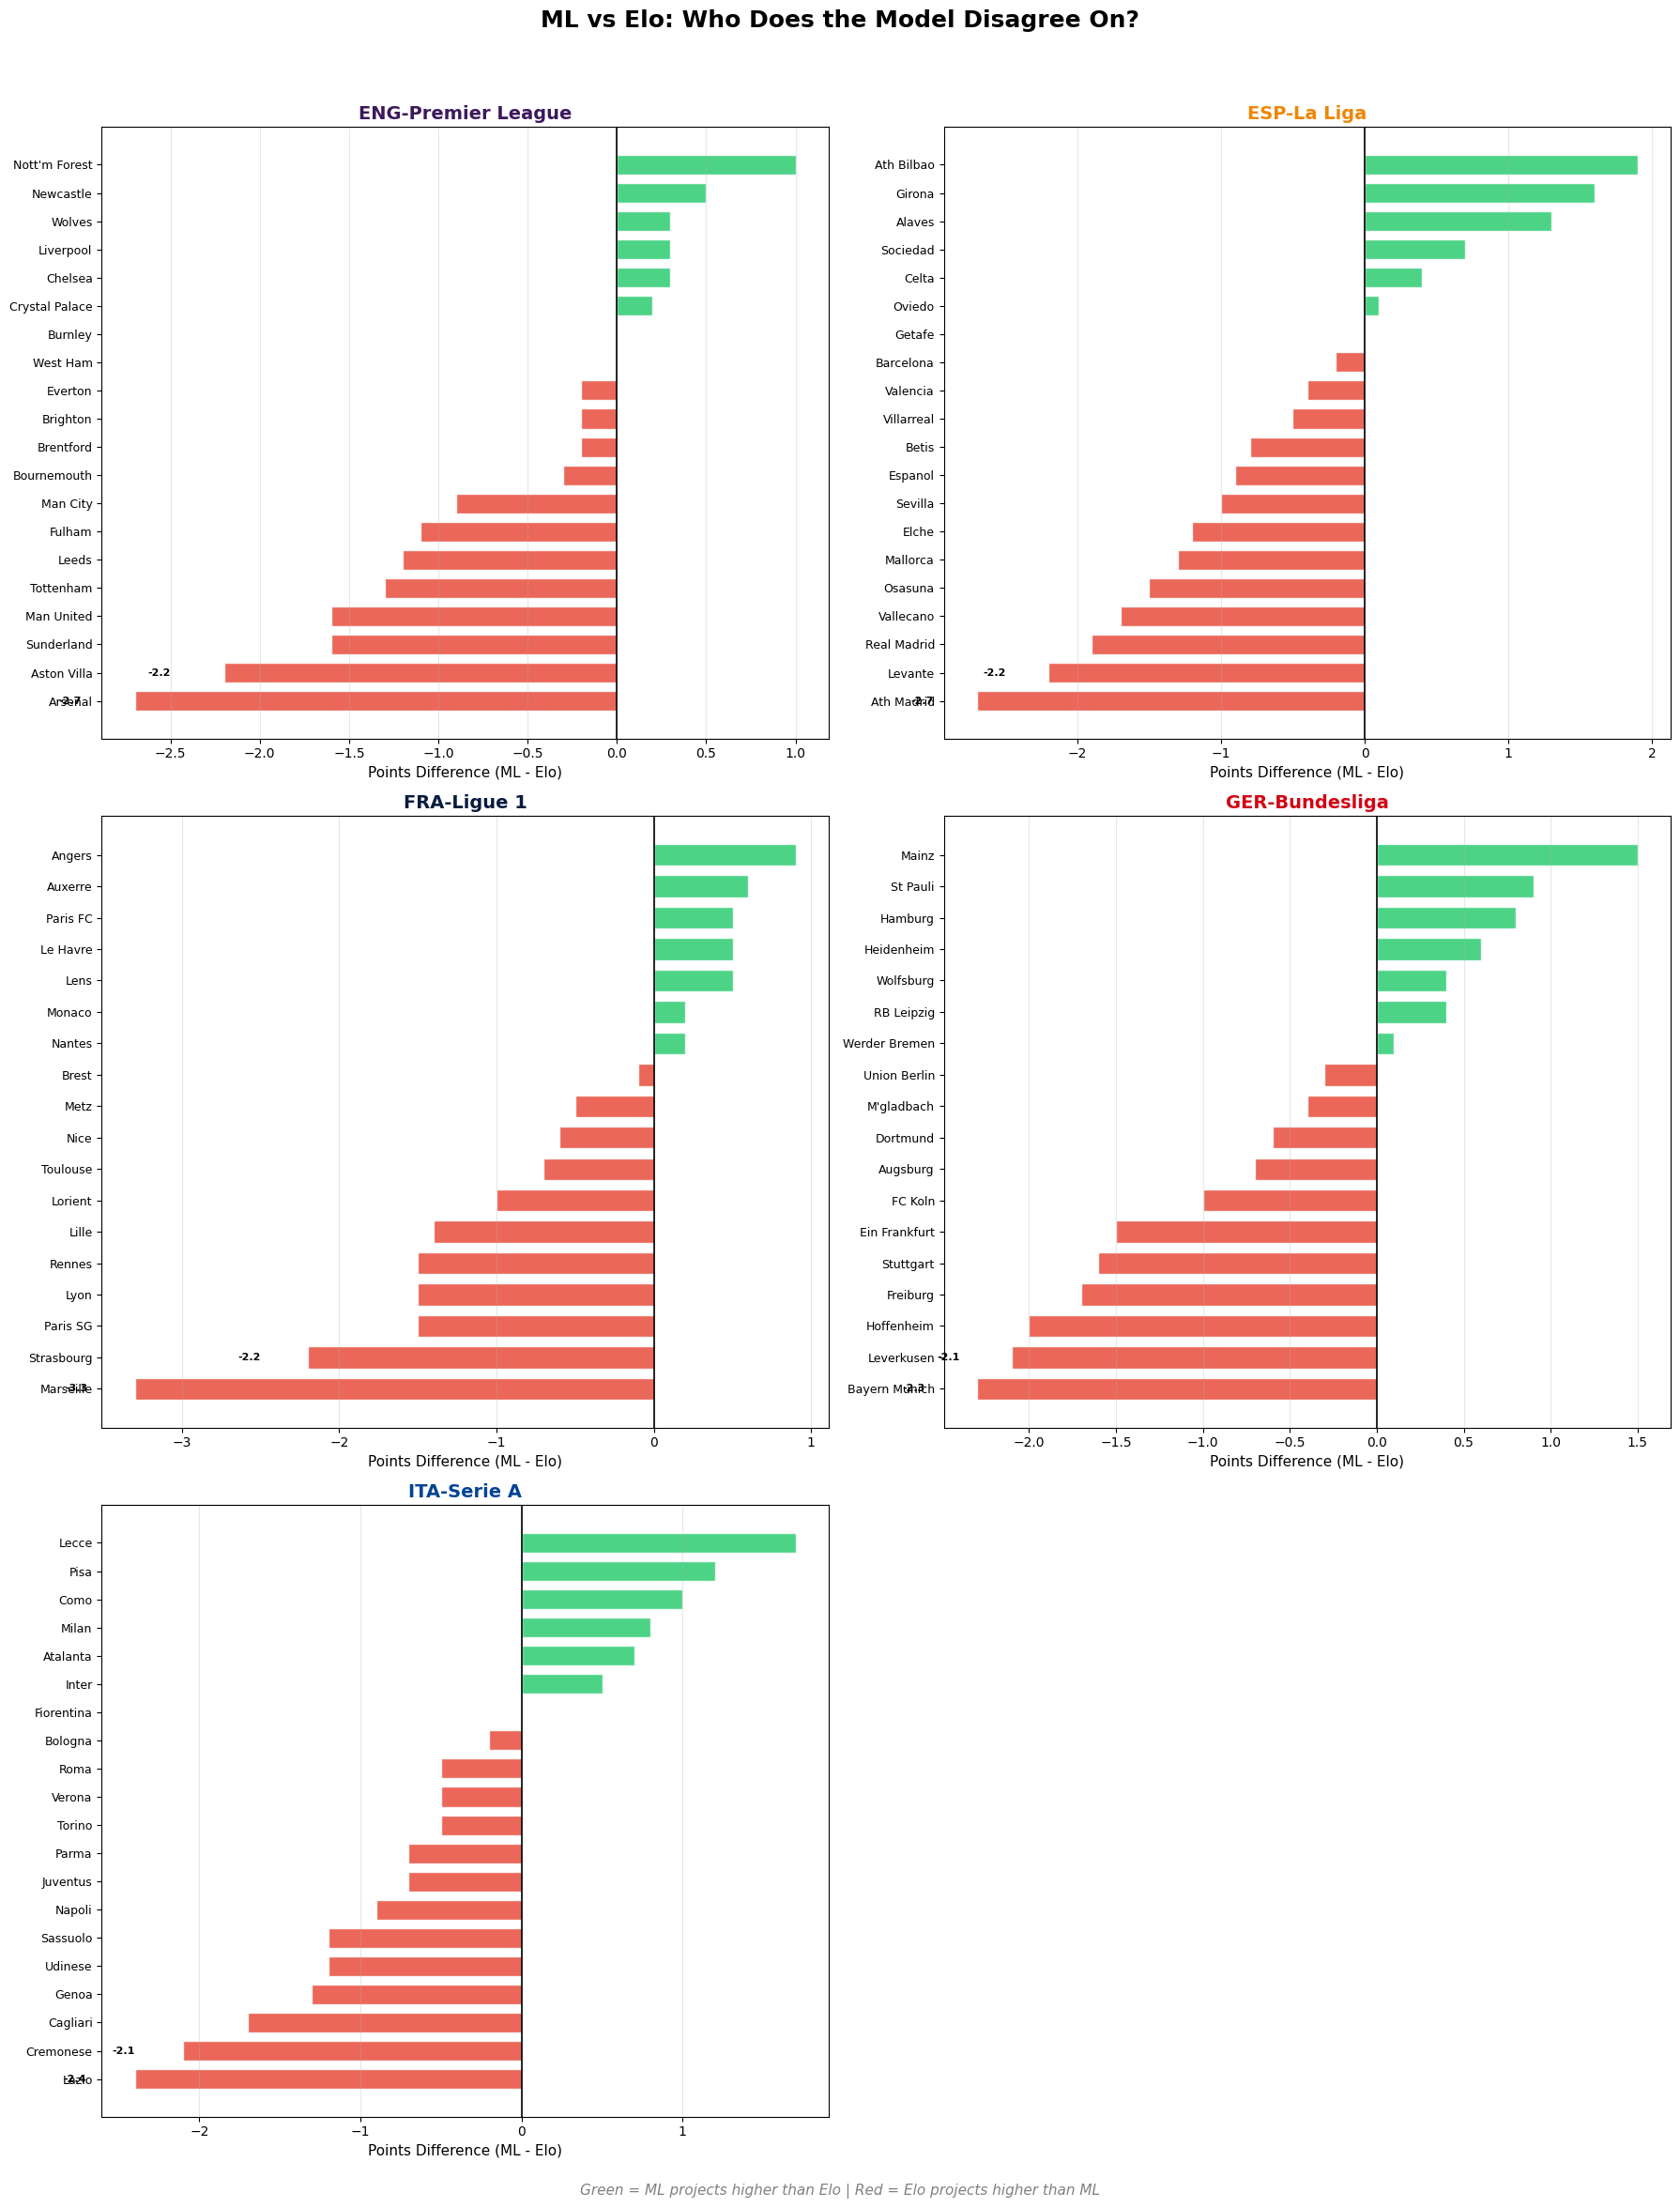

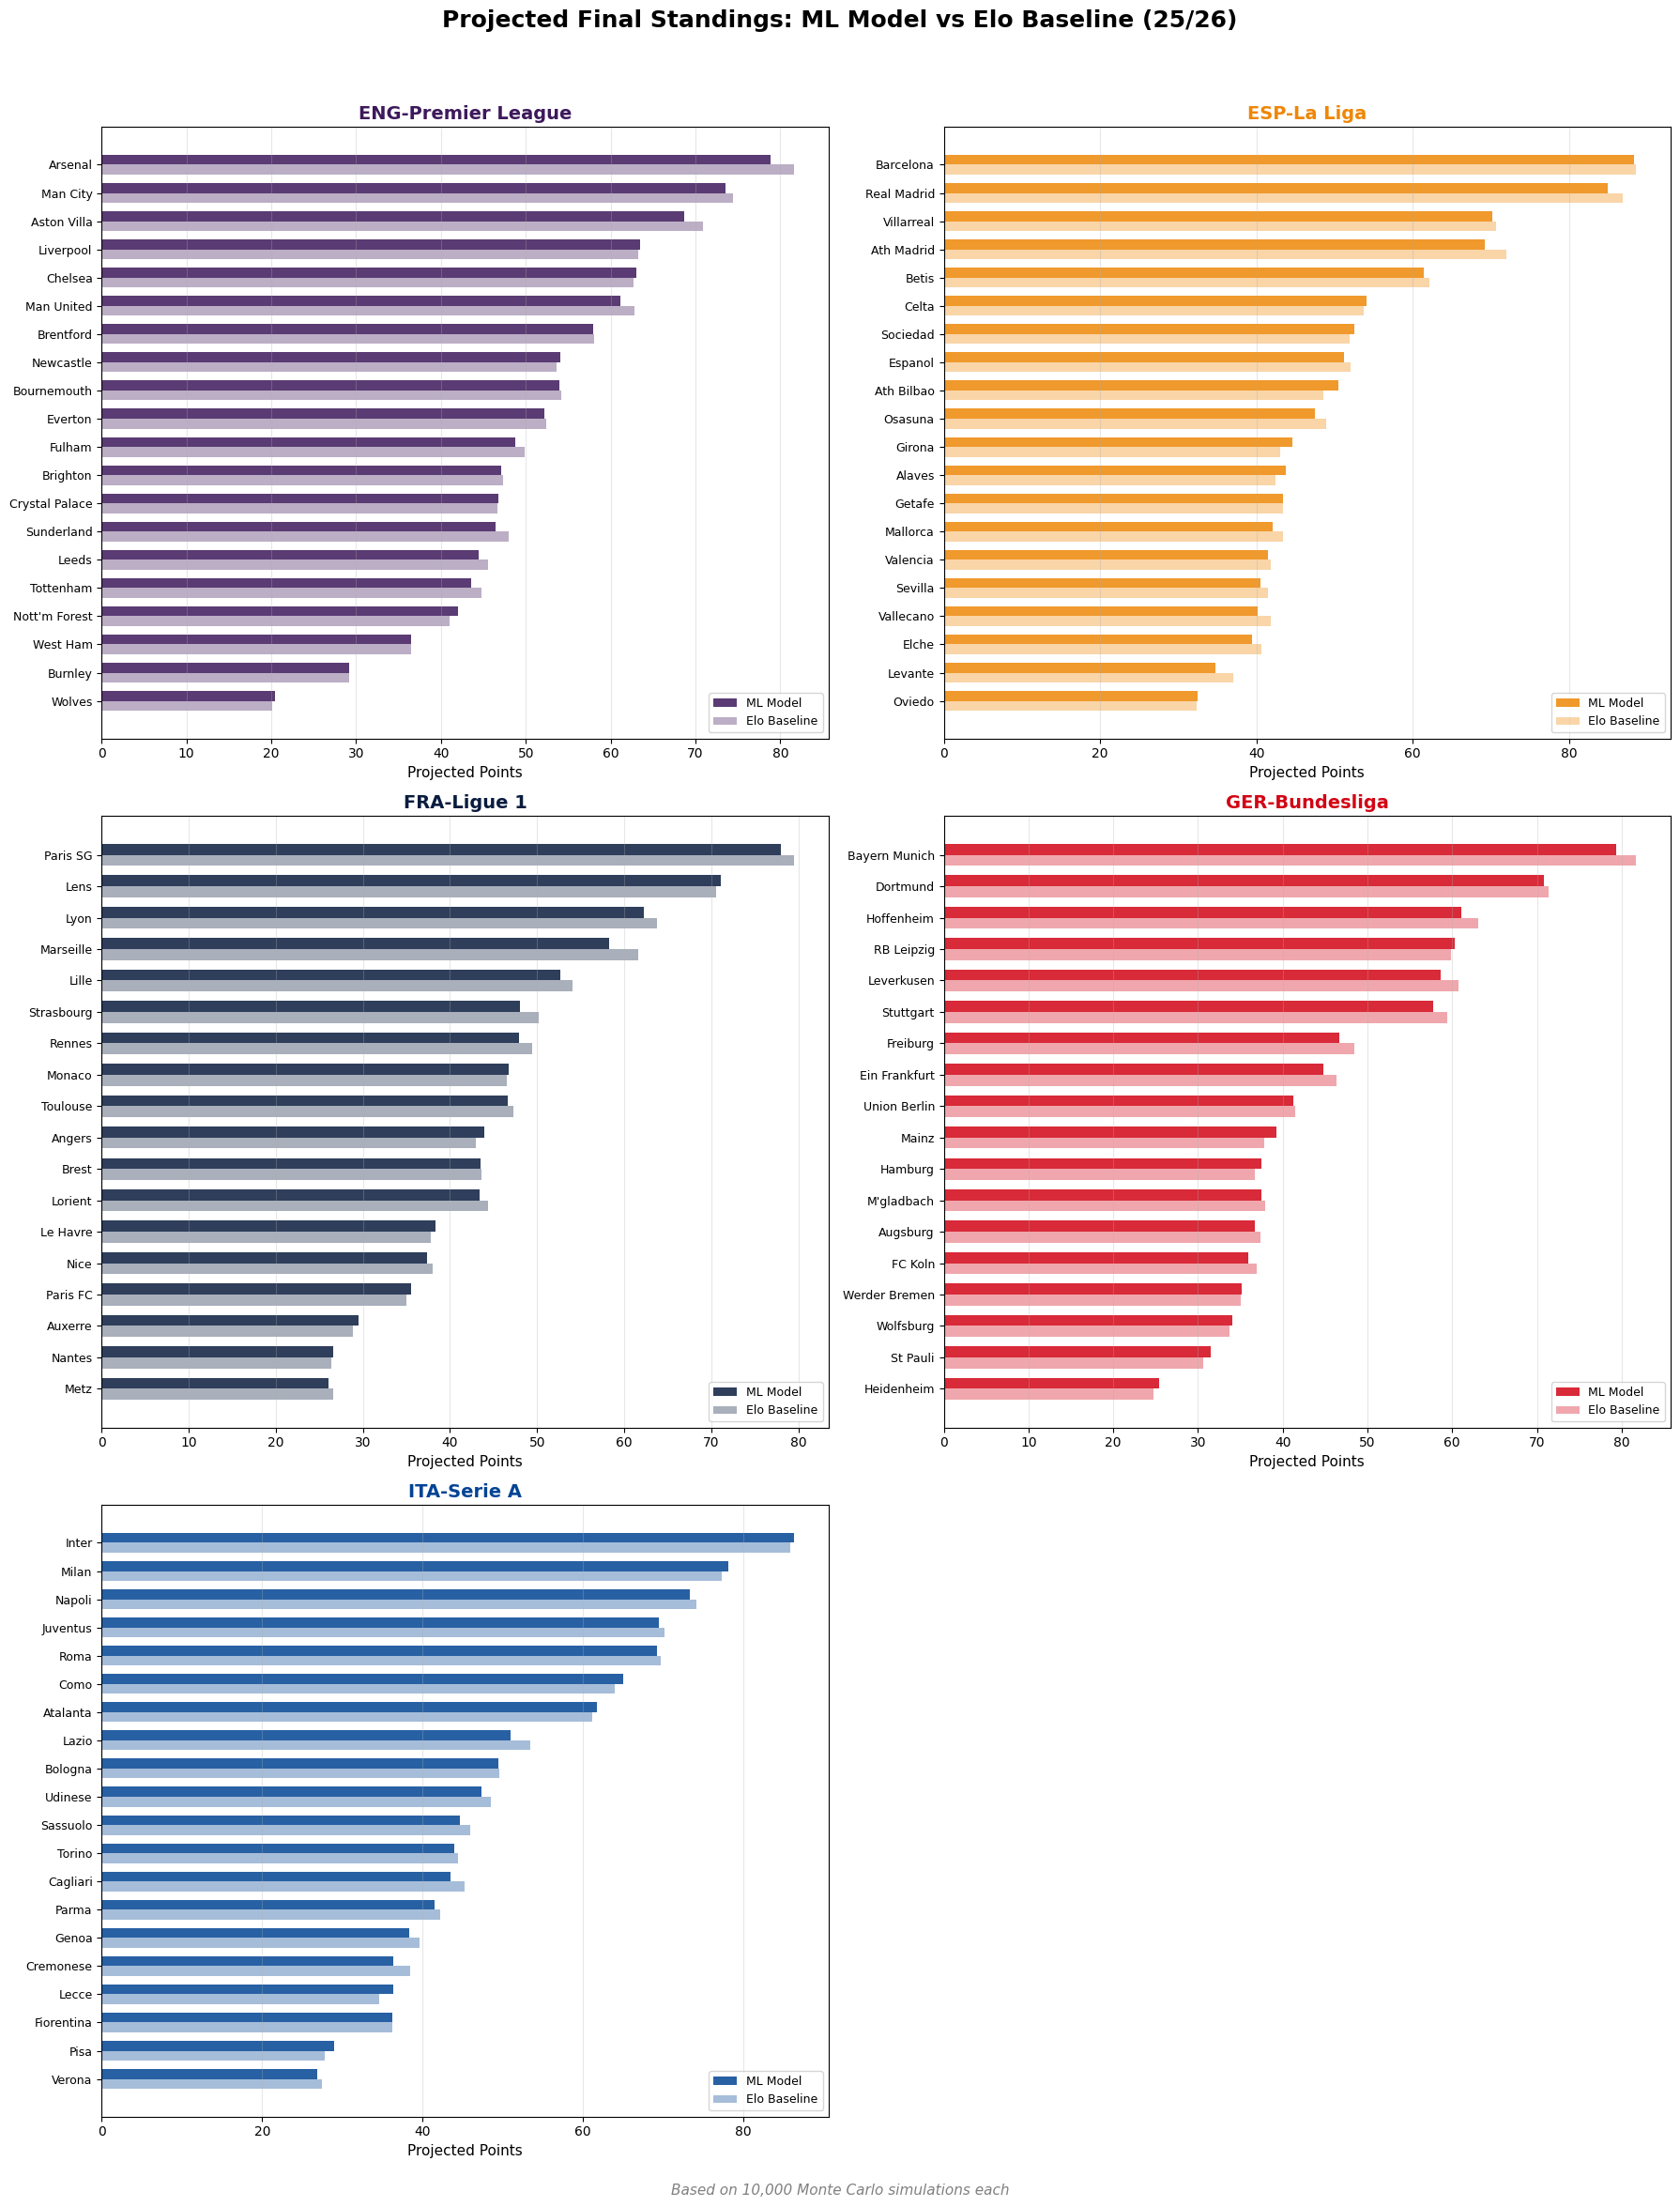


Saved charts:
  data\results\ML_vs_Elo_Difference.png
  data\results\ML_vs_Elo_Standings.png

Top 10 biggest ML vs Elo disagreements:
  Ath Bilbao             (ESP-La Liga              )  ML:  50.5  Elo:  48.6  Diff:  +1.9
  Lecce                  (ITA-Serie A              )  ML:  36.3  Elo:  34.6  Diff:  +1.7
  Girona                 (ESP-La Liga              )  ML:  44.6  Elo:  43.0  Diff:  +1.6
  Mainz                  (GER-Bundesliga           )  ML:  39.3  Elo:  37.8  Diff:  +1.5
  Alaves                 (ESP-La Liga              )  ML:  43.8  Elo:  42.5  Diff:  +1.3
  Pisa                   (ITA-Serie A              )  ML:  29.0  Elo:  27.8  Diff:  +1.2
  Nott'm Forest          (ENG-Premier League       )  ML:  42.0  Elo:  41.0  Diff:  +1.0
  Como                   (ITA-Serie A              )  ML:  65.0  Elo:  64.0  Diff:  +1.0
  Angers                 (FRA-Ligue 1              )  ML:  43.9  Elo:  43.0  Diff:  +0.9
  St Pauli               (GER-Bundesliga           )  ML:  31.5 

In [6]:
# =============================================================================
# Cell 6: Final Comparison Visualization
# =============================================================================

LEAGUE_COLORS = {
    'ENG-Premier League': '#3d195b',
    'ESP-La Liga':        '#ee8707',
    'GER-Bundesliga':     '#d20515',
    'ITA-Serie A':        '#024494',
    'FRA-Ligue 1':        '#091c3e',
}

# ---- CHART 1: ML vs Elo Difference (Who does the ML model love?) ----
fig, axes = plt.subplots(3, 2, figsize=(18, 24))
axes = axes.flatten()

for idx, league in enumerate(sorted(comparison['league'].unique())):
    ax = axes[idx]
    lg = comparison[comparison['league'] == league].sort_values('ml_vs_elo', ascending=True)
    color = LEAGUE_COLORS.get(league, '#333333')
    n_teams = len(lg)
    y_pos = np.arange(n_teams)
    
    # Bar chart: positive = ML higher, negative = Elo higher
    bar_colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in lg['ml_vs_elo'].values]
    ax.barh(y_pos, lg['ml_vs_elo'].values, height=0.7, color=bar_colors, edgecolor='white', alpha=0.85)
    
    # Zero line
    ax.axvline(x=0, color='black', linewidth=1.2, linestyle='-')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(lg['team'].values, fontsize=9)
    ax.set_xlabel('Points Difference (ML - Elo)', fontsize=11)
    ax.set_title(league, fontsize=14, fontweight='bold', color=color)
    ax.grid(axis='x', alpha=0.3)
    
    # Annotate notable differences
    for i, (_, r) in enumerate(lg.iterrows()):
        if abs(r['ml_vs_elo']) > 2:
            ax.text(r['ml_vs_elo'] + (0.3 if r['ml_vs_elo'] > 0 else -0.3),
                    i, f'{r["ml_vs_elo"]:+.1f}', va='center',
                    ha='left' if r['ml_vs_elo'] > 0 else 'right',
                    fontsize=8, fontweight='bold')

axes[5].set_visible(False)

fig.suptitle('ML vs Elo: Who Does the Model Disagree On?',
             fontsize=18, fontweight='bold', y=0.98)
fig.text(0.5, 0.01,
         'Green = ML projects higher than Elo | Red = Elo projects higher than ML',
         ha='center', fontsize=11, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
diff_path = os.path.join(RESULTS_DIR, 'ML_vs_Elo_Difference.png')
plt.savefig(diff_path, dpi=150, bbox_inches='tight')
plt.show()

# ---- CHART 2: Side-by-Side Projected Standings ----
fig2, axes2 = plt.subplots(3, 2, figsize=(18, 24))
axes2 = axes2.flatten()

for idx, league in enumerate(sorted(comparison['league'].unique())):
    ax = axes2[idx]
    lg = comparison[comparison['league'] == league].sort_values('ml_projected', ascending=True)
    color = LEAGUE_COLORS.get(league, '#333333')
    n_teams = len(lg)
    y_pos = np.arange(n_teams)
    bar_height = 0.35
    
    # ML bars
    ax.barh(y_pos + bar_height/2, lg['ml_projected'].values, height=bar_height,
            color=color, alpha=0.85, label='ML Model')
    # Elo bars
    ax.barh(y_pos - bar_height/2, lg['elo_projected'].values, height=bar_height,
            color=color, alpha=0.35, label='Elo Baseline')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(lg['team'].values, fontsize=9)
    ax.set_xlabel('Projected Points', fontsize=11)
    ax.set_title(league, fontsize=14, fontweight='bold', color=color)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(axis='x', alpha=0.3)

axes2[5].set_visible(False)

fig2.suptitle('Projected Final Standings: ML Model vs Elo Baseline (25/26)',
              fontsize=18, fontweight='bold', y=0.98)
fig2.text(0.5, 0.01,
          f'Based on {N_SIMULATIONS:,} Monte Carlo simulations each',
          ha='center', fontsize=11, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
standings_path = os.path.join(RESULTS_DIR, 'ML_vs_Elo_Standings.png')
plt.savefig(standings_path, dpi=150, bbox_inches='tight')
plt.show()

# --- Summary ---
print(f'\nSaved charts:')
print(f'  {diff_path}')
print(f'  {standings_path}')

# --- Biggest disagreements ---
print(f'\nTop 10 biggest ML vs Elo disagreements:')
top_diff = comparison.nlargest(10, 'ml_vs_elo', keep='first')[['team', 'league', 'ml_projected', 'elo_projected', 'ml_vs_elo']]
for _, r in top_diff.iterrows():
    print(f'  {r["team"]:22s} ({r["league"]:25s})  ML: {r["ml_projected"]:5.1f}  Elo: {r["elo_projected"]:5.1f}  Diff: {r["ml_vs_elo"]:+5.1f}')

print(f'\nBottom 10 (Elo rates higher):')
bot_diff = comparison.nsmallest(10, 'ml_vs_elo', keep='first')[['team', 'league', 'ml_projected', 'elo_projected', 'ml_vs_elo']]
for _, r in bot_diff.iterrows():
    print(f'  {r["team"]:22s} ({r["league"]:25s})  ML: {r["ml_projected"]:5.1f}  Elo: {r["elo_projected"]:5.1f}  Diff: {r["ml_vs_elo"]:+5.1f}')

print(f'\n{"=" * 65}')
print(f'Phase 6 complete.')
print(f'  Model accuracy: {accuracy:.1%}')
print(f'  Output files:')
print(f'    - {comp_path}')
print(f'    - {importance_path}')
print(f'    - {diff_path}')
print(f'    - {standings_path}')